### check python version

In [1]:
from platform import python_version
print(python_version())
import sys
for i in range(len(sys.path)):
    print(sys.path[i])

3.7.6
/Users/c5303486/OneDrive - SAP SE/Desktop/Speaker-Identification/rene experimental
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload

/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/aeosa
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
/Users/c5303486/.ipython


# MAIN

In [2]:
#import dlib
import os
import wave
import numpy as np
#import speech_recognition as sr
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.playback import play
from pydub.effects import normalize
#import spacy
from wave import open as open_wave # for reading wave files
import pylab # for spectogram
import pandas as pd
import librosa

## spectogram

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


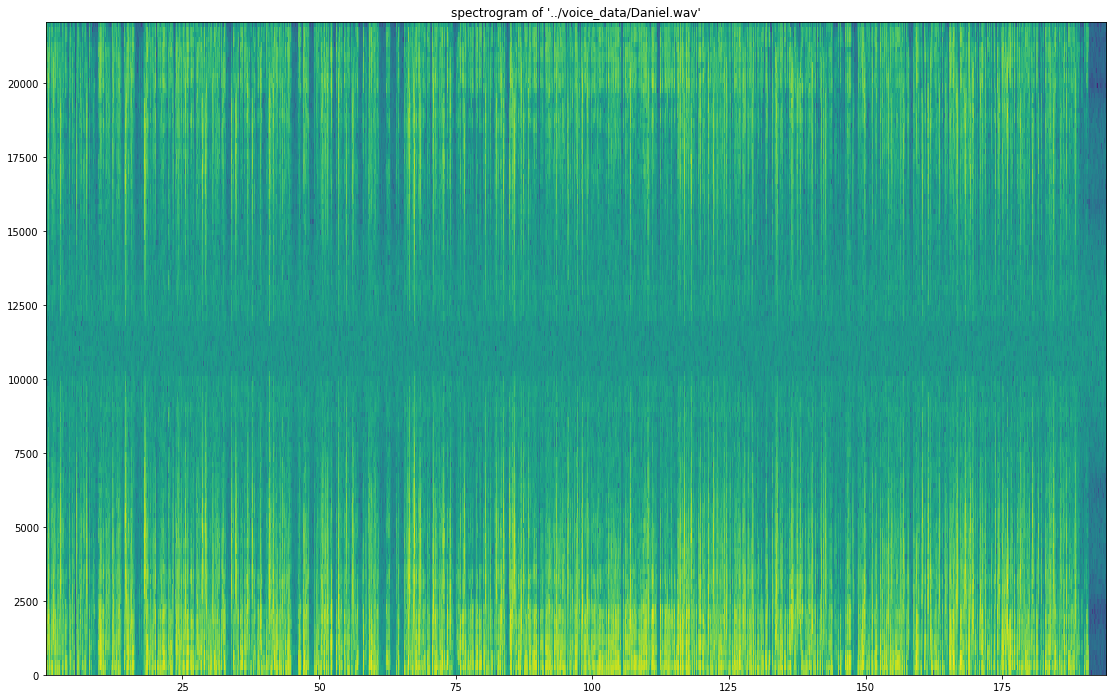

In [6]:
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'Int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
if __name__ == '__main__':
    wav_file = r"../voice_data/Daniel.wav"
    graph_spectrogram(wav_file)

# IMPORTING AND PREPROCESSING OF DATA

In [8]:
data_path = "../voice_data/"
def fetch_voice_data(url=data_path): 
    audios = []
    for audio in os.listdir(data_path):
        if audio.endswith('.wav'):
            audios.append(audio)
    return audios

#adios = fetch_voice_data()
audios = fetch_voice_data()
print(str(len(audios)) + " audio files loaded")

def file_to_npy(path_to_file):
    audioData, sampleRate = librosa.load(path_to_file)
    print(audioData)
    print(audioData.shape)
    print(sampleRate)
    y, sr = librosa.load(path_to_file, mono = true, duration = 30, sr = 44100)
    print(y.size)
    return y

def npy_to_df(numpy_array, sample_rate, row_length, row_count):
    numpy_array = librosa.to_mono(numpy_array)
    numpy_array = numpy_array[0:sample_rate*row_length*row_count]
    rows = np.empty((0,sample_rate*row_length), int)
    for i in range(row_count):
        row = numpy_array[0:sample_rate*row_length]
        numpy_array = numpy_array[sample_rate*row_length:]
        rows = np.vstack((rows, row))
    df = pd.DataFrame((rows), columns=range(sample_rate*row_length))
    return df

9 audio files loaded


## wave

In [10]:
def get_audio_params(file_path):
    wav_file = wave.open(file_path, 'r')
    #print(f"channels: {wav_file.getnchannels()}")
    print(f"sample rate: {wav_file.getframerate()}")
    #print(f"frames: {wav_file.getnframes()}")
    #print(f"sample width: {wav_file.getsampwidth()}")
    #print(f"params: {wav_file.getparams()}")
    print(f"length: {wav_file.getnframes()/wav_file.getframerate()} seconds")

for audio in audios:
    print(audio)
    get_audio_params(data_path + audio)

good-afternoon.wav
sample rate: 48000
length: 3.461333333333333 seconds
good-morning-lei.wav
sample rate: 48000
length: 2.136229166666667 seconds
Jakub.wav
sample rate: 44100
length: 77.53020408163265 seconds
LudvigElevator.wav
sample rate: 48000
length: 63.104 seconds
loud_quiet.wav
sample rate: 48000
length: 3.8367291666666667 seconds
good-morning.wav
sample rate: 48000
length: 2.604 seconds
Daniel.wav
sample rate: 44100
length: 97.00331065759637 seconds
good-morning-lars.wav
sample rate: 44100
length: 2.670907029478458 seconds
Richard.wav
sample rate: 44100
length: 101.82854875283446 seconds


In [11]:
fileWave = open_wave(data_path + audios[0],'rb')
wframes = fileWave.getnframes()
waveFrames = fileWave.readframes(wframes)
waveData = np.frombuffer(waveFrames, dtype=np.int16)
print(len(waveData)/44100/2)

3.767437641723356


## librosa

In [17]:
frames = []
# Load the audio as a waveform `y`
# Store the sampling rate as `sr`
y = [None] * len(audios)
sr = [None] * len(audios)
for i in range(len(audios)):
    y[i], sr[i] = librosa.load(data_path + audios[i], sr = 44100)
    minidf = npy_to_df(y[i], sr[i], 1, 1)
    label = audios[i].split(".")
    label.pop()
    minidf["name"] = "".join(label)
    frames.append(minidf)
result = pd.concat(frames)
result.shape
result

,0,1,2,3,4,5,6,7,8,9,...,44091,44092,44093,44094,44095,44096,44097,44098,44099,name
0,-0.001891,-0.002053,-0.001923,-0.002221,-0.002108,-0.002069,-0.002022,-0.002139,-0.002115,-0.002128,...,-0.251081,-0.310222,-0.352378,-0.379023,-0.390952,-0.388824,-0.377944,-0.362328,-0.341957,good-afternoon
0,-0.000013,0.000040,0.000005,0.000001,0.000030,-0.000071,0.000030,-0.000042,0.000036,-0.000035,...,-0.002903,-0.002856,-0.002787,-0.002713,-0.002635,-0.002697,-0.002654,-0.002716,-0.002619,good-morning-lei
0,0.000183,0.000076,-0.000732,-0.000870,-0.000412,-0.000458,-0.000336,-0.000549,-0.000595,-0.000305,...,0.016785,0.014847,0.012833,0.009964,0.007477,0.004181,0.001572,-0.000946,-0.003769,Jakub
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015141,0.014784,0.014276,0.013789,0.013575,0.013661,0.013918,0.014072,0.013992,LudvigElevator
0,0.000010,0.000023,0.000002,0.000018,-0.000020,-0.000006,-0.000007,-0.000009,-0.000004,-0.000045,...,0.000502,0.000418,0.000526,0.000456,0.000525,0.000466,0.000458,0.000414,0.000410,loud_quiet
0,-0.000111,-0.000268,-0.000320,-0.000281,-0.000318,-0.000450,-0.000422,-0.000260,-0.000393,-0.000513,...,-0.102822,-0.088588,-0.073830,-0.058828,-0.045156,-0.033425,-0.023969,-0.017731,-0.012892,good-morning
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,-0.000015,0.000015,-0.000031,0.000046,...,0.015884,0.018661,0.019745,0.020447,0.020950,0.019028,0.015289,0.011673,0.009705,Daniel
0,-0.000015,0.000031,-0.000046,0.000046,-0.000031,0.000031,0.000031,-0.000061,0.000061,-0.000031,...,-0.009903,-0.009109,-0.007980,-0.006683,-0.005142,-0.003784,-0.002319,-0.001144,0.000122,good-morning-lars
0,0.000000,0.000015,-0.000015,0.000000,0.000015,-0.000015,0.000015,0.000000,-0.000015,0.000015,...,0.007889,0.006577,0.002716,-0.000244,0.002106,0.000549,-0.000870,0.002579,0.000793,Richard


# choosing the best classification model

In [18]:
import pandas as pd 
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split
data  =  result
#Create Dependent and Independent Datasets based on our Dependent #and Independent features
X= data[range(44100)]
y= data["name"]
#Split the Data into Training and Testing sets with test size as #20%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

In [19]:
classifiers = []
model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)

In [124]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s"%(clf, acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is %s"%(clf, cm))

Accuracy of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) is 0.5
Confusion Matrix of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) is [[2 2 2 1]
 [1 0 2 1